# Species comparison of n-grams

In [111]:
import pandas as pd
from collections import Counter
import networkx as nx
import numpy as np
import ngramUtilities
import matplotlib.pyplot as plt
import seaborn as sns
import entropyCalc

In [112]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01


In [113]:
# General Info
multi_IDs = ['IPR000980','IPR000719','IPR000242','IPR006020','IPR020635'] #,'IPR000387', 'IPR003595'] Note these last two have to do with the Tensin domains that don't have an annotated PTP domain but have predicted phosphatase activity that is mapped to these domain IDs.


In [114]:
species_names = {'Homo sapiens':'H_sapiens',
                 'Mus musculus':'M_musculus',
                 'Rattus norvegicus':'R_norvegicus',
                 'Oryctolagus cuniculus':'O_cuniculus',
                 'Gallus gallus':'G_gallus',
                 'Xenopus tropicalis':'X_tropicalis',
                 'Danio rerio':'D_rerio',
                 'Carassius auratus':'C_auratus',
                 'Ciona intestinalis':'C_intestinalis',
                 'Strongylocentrotus purpuratus':'S_purpuratus',
                 'Drosophila melanogaster':'D_melanogaster',
                 'Caenorhabditis elegans':'C_elegans', 
                 'Nematostella vectensis':'N_vectensis',
                 'Trichoplax adhaerens':'T_adhaerens',
                 'Monosiga brevicollis':'M_brevicollis',
                 'Capsaspora owczarzaki (strain ATCC 30864)':'C_owczarzaki',
                 'Sphaeroforma arctica JP610':'S_arctica',
                 'Acanthamoeba castellanii':'A_castellanii',
                 'Dictyostelium discoideum':'D_discoideum',
                 'Saccharomyces cerevisiae':'S_cerevisiae'}

reference_files = {}
for species in species_names:
    reference_files[species] = 'data/Current_Multispecies_pTyr/'+species_names[species]+'Full_pTyr_System_Reference_File_May12_2025.csv'
    

In [115]:
# Creating a dictionary to store information in across species
species_list = list(reference_files.keys())
species_summary = {}
species_all_ngrams = {}

In [116]:
for species in species_list:
    
    species_summary[species] = {}
    reference_file = reference_files[species]

    df = ngramUtilities.import_reference_file(reference_file)
    df,_ = ngramUtilities.add_Interpro_ID_architecture(df)
    spec_interpro_conv = ngramUtilities.generate_interpro_conversion(df)
    
    # Performing the n-gram analysis
    all_doms = [k for k in spec_interpro_conv.keys()]
    adj_comp, _, _,rm_comp, _ = ngramUtilities.full_ngram_analysis(df, all_doms, min_arch=1,readable_flag=0, max_node_len=100,max_ngram=100) # All possible
    adj_df, df, ngram_dict,removed_ngrams, interpro_conv = ngramUtilities.full_ngram_analysis(df, multi_IDs, min_arch=1,readable_flag=0, max_node_len=100,max_ngram=100) # Only the pTyr system
    
    # Now getting the counts for individual domains and then filtering to only the ones associated with the system.
    ngram_list = Counter(sum(df['Interpro Domain Architecture IDs'].str.split('|'),[]))
    ngram_counts = {k:v for k,v in ngram_list.items() if k in multi_IDs}

    if species == 'Homo sapiens':
        ptyr_doms = {}
        for interpro_id in multi_IDs:
            if interpro_id in interpro_conv:
                ptyr_doms[interpro_id] = interpro_conv[interpro_id]
    
    species_summary[species]['Reference Data'] = df
    species_summary[species]['Adjacency Dataframe'] = adj_df
    species_summary[species]['Complete Adjacency'] = adj_comp
    species_summary[species]['N-gram Uniprot IDs'] = ngram_dict
    species_summary[species]['Removed N-grams'] = removed_ngrams
    species_summary[species]['Complete Removed N-grams'] = rm_comp
    species_summary[species]['Domain Counts'] = ngram_counts
    
    species_all_ngrams[species] = set(adj_df.index).union(removed_ngrams)



Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to gene

In [117]:
species_adj_orig = {species:sum_info['Complete Adjacency'] for species, sum_info in species_summary.items()}

In [118]:
species_removed_ngrams = {species:sum_info['Complete Removed N-grams'] for (species, sum_info) in species_summary.items()}

## Setting up aesthetic elements for the network visualization

In [119]:
domain_categories = {'Reader':['IPR006020','IPR000980'], 
                     'Writer':['IPR000719','IPR020635'],
                     'Eraser':['IPR000242']} #,'IPR000387','IPR003595']}

v_list = []
k_list = []
for (k,v) in domain_categories.items():
    v_list += v
    dup_k = [k]*len(v)
    k_list += dup_k
domain_categories = dict(zip(v_list, k_list))
dom_colors = {}
writer = '#22c919' #orange
eraser = '#c019c9' #purple
reader = '#f2b120' #green
color_cats = {'Reader':reader, 'Writer':writer, 'Eraser':eraser,'Multiple':'#3b78d6'}

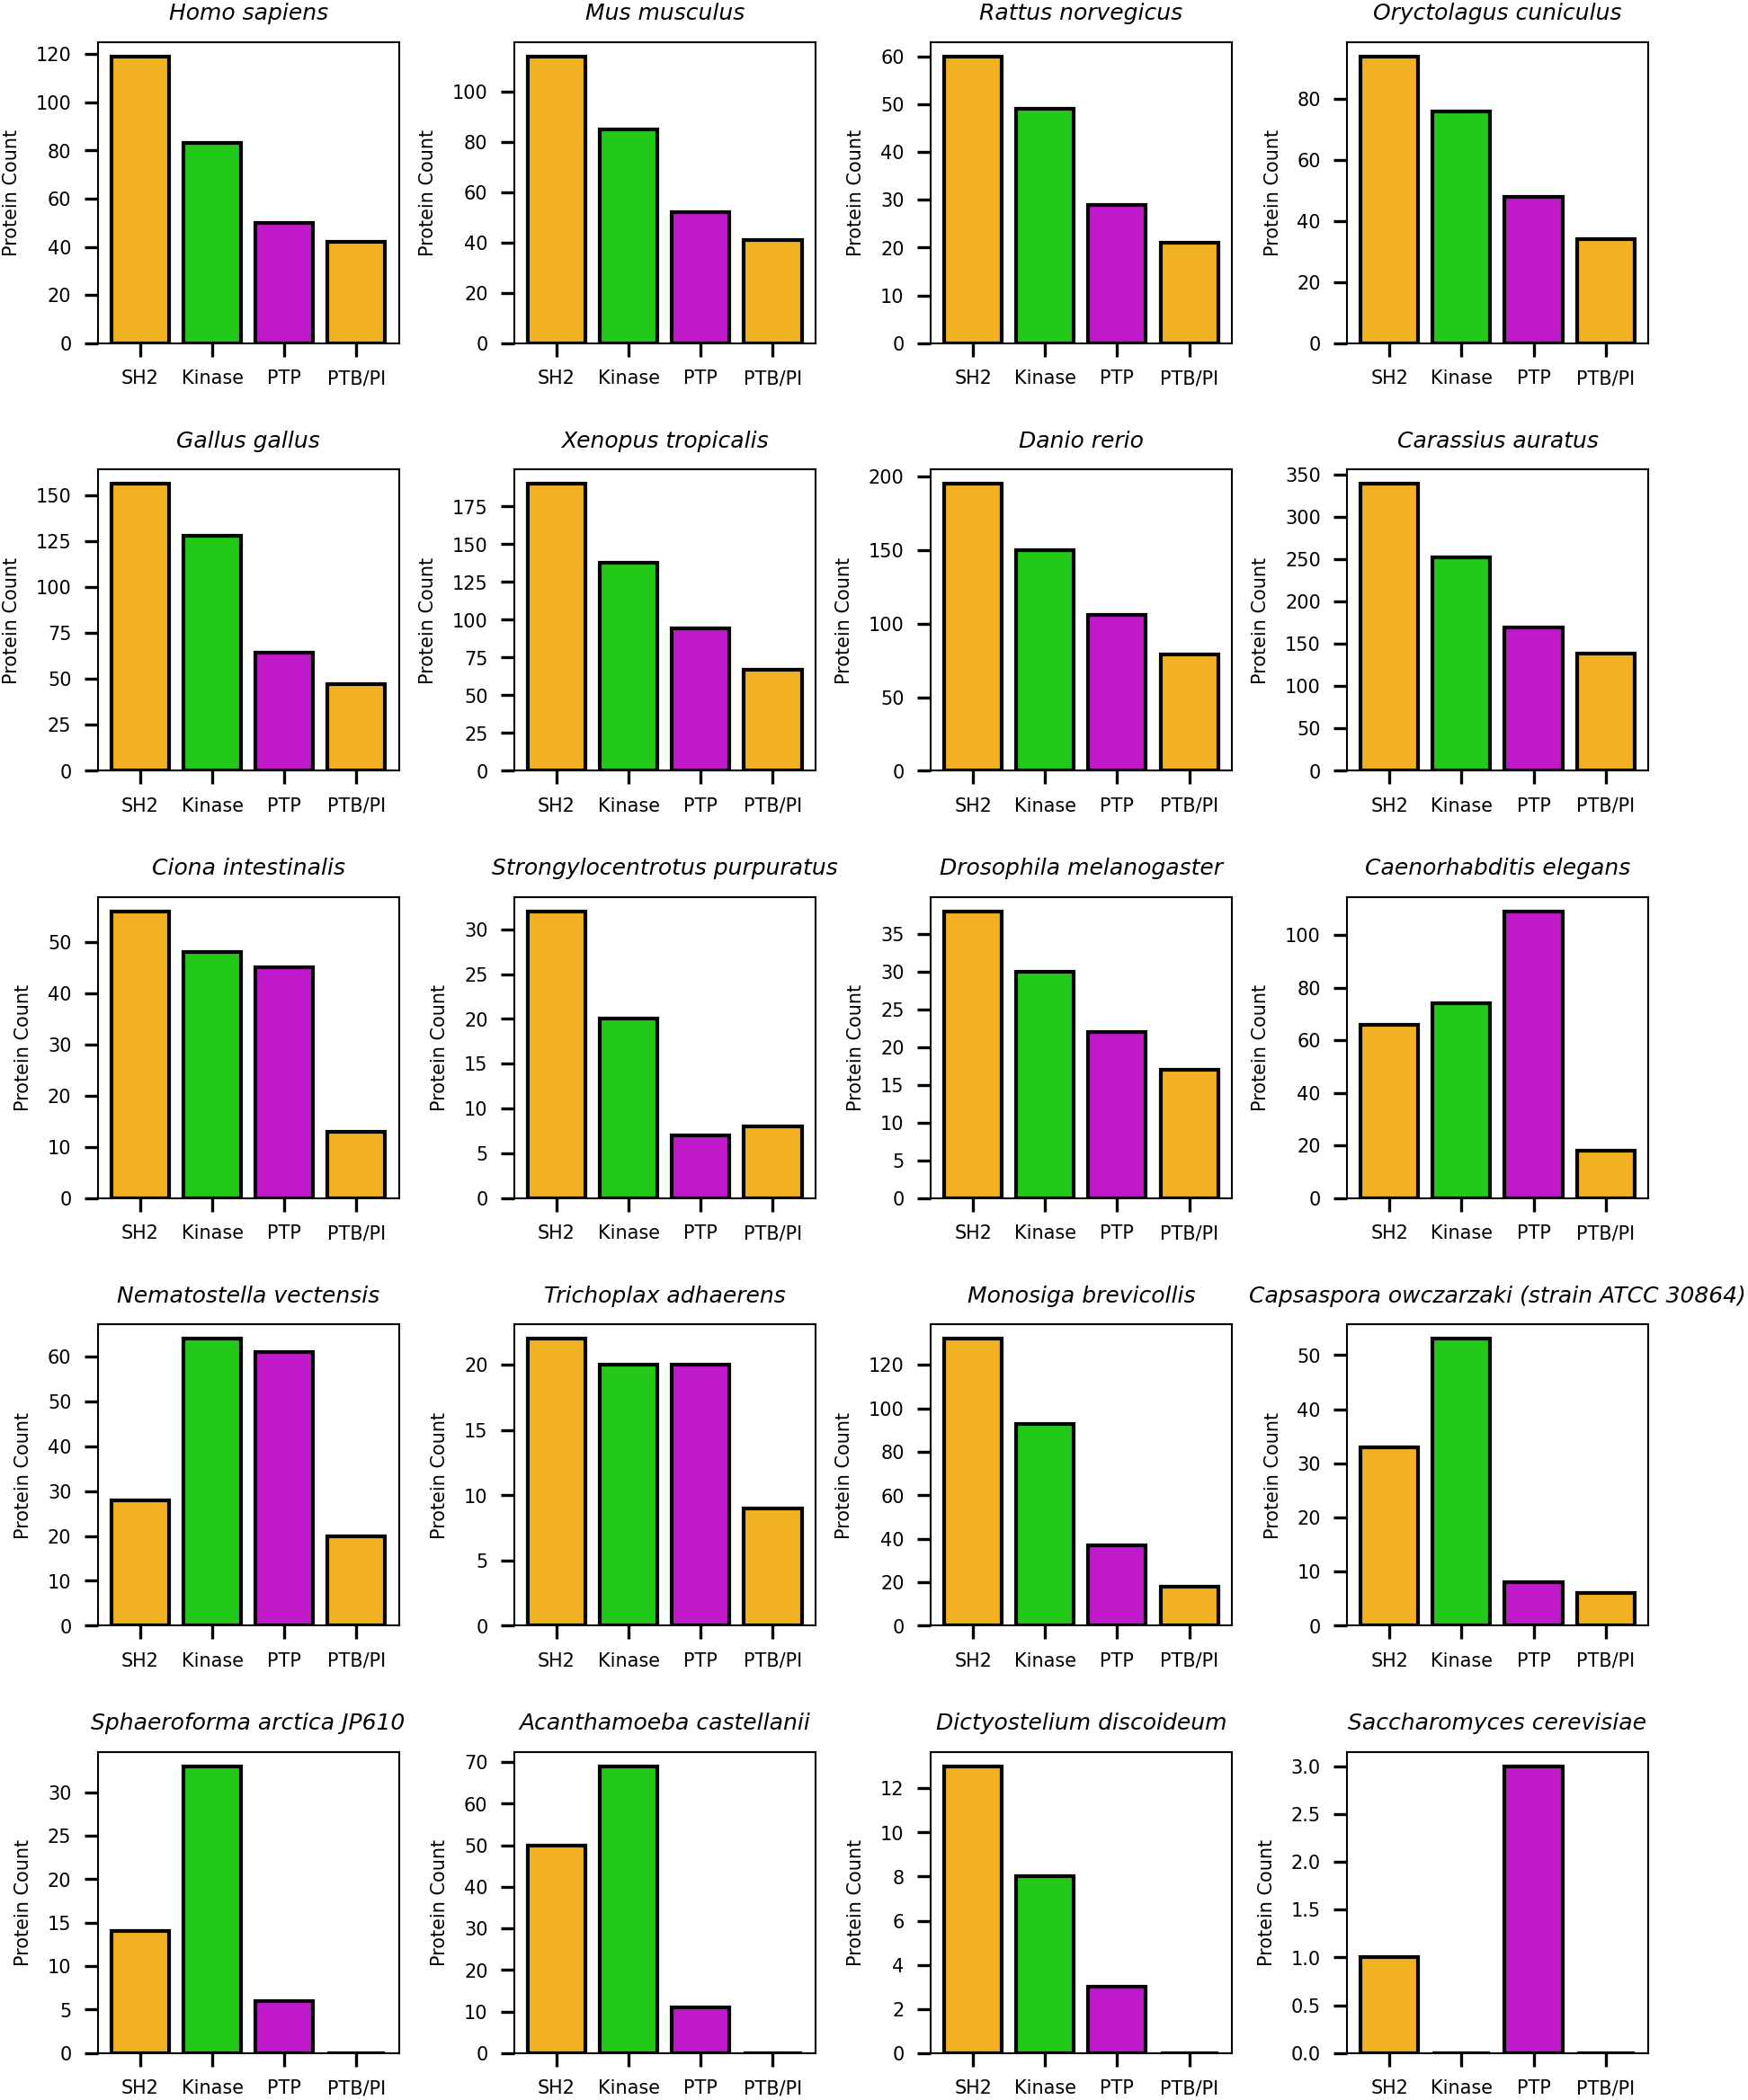

In [120]:
tk_doms = [k for k in ptyr_doms.keys()]
dom_names = [v for v in ptyr_doms.values()]
tk_df = pd.DataFrame(0, index=list(species_summary.keys()), columns=tk_doms)
subplotCount = 1
plt.figure(figsize=(6.25,8), dpi=300, layout = 'tight')
for species in species_summary:
    counts = species_summary[species]['Domain Counts']
    for tk in tk_doms:
        if tk in counts:
            tk_df.loc[species, tk] = counts[tk]
    plt.subplot(5,4,subplotCount)
    plt.bar(height=tk_df.loc[species],x=tk_doms, color = ['#f2b120','#22c919','#c019c9','#f2b120','#005AFF',],edgecolor = 'black')
    plt.title(species,style = 'italic')
    plt.xticks(tk_doms,labels=['SH2','Kinase','PTP','PTB/PI'])#,'Tyr_Pase_cat','Tyr_Pase_dom'])
    plt.ylabel('Protein Count')
    #plt.ylim(0,325)
    ax = plt.gca()
    ax.set_box_aspect(1)
    subplotCount +=1
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure 8 Phosphorylation Domain Evolution/Species pTyr Domain Breakdown.svg')

## Generating the network and node attributes for each species

In [121]:
species_2_plt = ['Homo sapiens','Mus musculus','Drosophila melanogaster','Caenorhabditis elegans', 
                 'Nematostella vectensis','Monosiga brevicollis','Sphaeroforma arctica JP610','Acanthamoeba castellanii',
                 'Dictyostelium discoideum']

In [122]:
species_plt_names = {'Homo sapiens':'H. sapiens',
                 'Mus musculus':'M. musculus',
                 'Rattus norvegicus':'R. norvegicus',
                 'Oryctolagus cuniculus':'O. cuniculus',
                 'Gallus gallus':'G. gallus',
                 'Xenopus tropicalis':'X. tropicalis',
                 'Danio rerio':'D. rerio',
                 'Carassius auratus':'C. auratus',
                 'Ciona intestinalis':'C. intestinalis',
                 'Strongylocentrotus purpuratus':'S. purpuratus',
                 'Drosophila melanogaster':'D. melanogaster',
                 'Caenorhabditis elegans':'C. elegans', 
                 'Nematostella vectensis':'N. vectensis',
                 'Trichoplax adhaerens':'T. adhaerens',
                 'Monosiga brevicollis':'M. brevicollis',
                 'Capsaspora owczarzaki (strain ATCC 30864)':'C. owczarzaki',
                 'Sphaeroforma arctica JP610':'S. arctica',
                 'Acanthamoeba castellanii':'A. castellanii',
                 'Dictyostelium discoideum':'D. discoideum',
                 'Saccharomyces cerevisiae':'S. cerevisiae'}

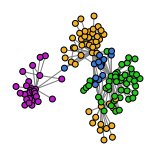

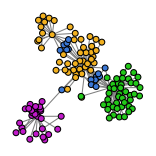

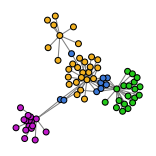

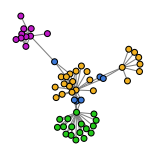

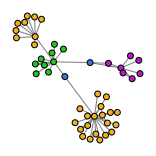

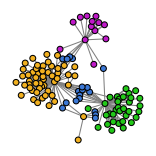

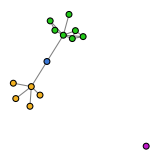

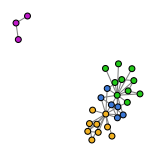

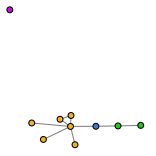

In [123]:
# Generating the network from the adjacency matrix.
G = {}
pos = {}
brding_ngrams = {}
#subplotCount = 1
#plt.figure(figsize=(1,1), dpi=300, layout = 'tight')
for species in species_summary:
    spec_adj = species_summary[species]['Adjacency Dataframe']
    G_spec = nx.from_pandas_adjacency(spec_adj)
    G_spec.remove_edges_from(nx.selfloop_edges(G_spec))
    pos[species]  = nx.spring_layout(G_spec, seed = 848, k =0.25) #Setting positions of each node based on the spring model
    br_grams = set()
    for node in G_spec.nodes():
        col = '#d3d3d3'
        sz = spec_adj.loc[node, node]
        new_flag = True
        for domain, type in domain_categories.items():
            
            if domain in node:
                if new_flag:
                    col = color_cats[type]
                    new_flag = False
                else:
                    br_grams.add(node)
                    col = color_cats['Multiple']              
        
        nx.set_node_attributes(G_spec, values={node:{'size':sz,'color':col}})
    brding_ngrams[species] = br_grams
    G[species] = G_spec
    if species in species_2_plt:
        node_attribs = dict(G_spec.nodes(data = True))
        plt.figure(figsize=(0.5,0.5),dpi = 300)
        nx.draw(G_spec, pos=pos[species], 
            node_color=[v['color'] for v in node_attribs.values()], 
            node_size = 2, 
            edgecolors= 'k',
            font_size=10, edge_color = '#808080', width = 0.25, linewidths = 0.25)
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/Species Networks/pY {species} Full.svg', transparent=True)
    
    node_attribs = dict(G_spec.nodes(data = True))
    plt.figure(figsize=(1,1),dpi = 300)
    nx.draw(G_spec, pos=pos[species], 
        node_color=[v['color'] for v in node_attribs.values()], 
        node_size = 2, 
        edgecolors= 'k',
        font_size=10, edge_color = '#808080', width = 0.25, linewidths = 0.25)
    plt.title(species_plt_names[species])
    plt.axis('on')
    plt.savefig(f'Figures/Manuscript Figures/Supplemental Figure Expanded Species pTyr Networks/pY {species}.svg')
    plt.close()
    




# Checking the similiarity of each species to the other

This will be done primarily based on the graphs themselves and whether they are isomorphic from each other.

In [124]:
# To check whether the architectures are mostly similar between species next going to compute the Jaccard Similarity index for just identified architectures. (Note not taking into account the number of each for the time being)
species_columns = {}
for species in species_adj_orig.keys():
    species_label = species.split(' ')
    species_label = species_label[0:2]
    species_label = ''.join([n[0] for n in species_label])
    species_columns[species] = species_label

species_archs = pd.DataFrame(columns=species_columns.values())
species_archs_count = species_archs.copy()
for species, adj in species_adj_orig.items():
    domain_archs = adj.columns
    spec_lab = species_columns[species]
    for arch in domain_archs:
        if arch not in species_archs.index:
            temp = [0]*len(species_adj_orig)
            species_archs.loc[arch] = temp
            species_archs_count.loc[arch] = temp
        species_archs_count[spec_lab][arch] = adj.loc[arch][arch]
        species_archs[spec_lab][arch] = 1


In [125]:
# Checking if any of the n-grams were omitted due to being in the removed n-grams 

for arch in species_archs.index:
    for species in species_removed_ngrams.keys():
        spec_lab = species_columns[species]
        if species_archs[spec_lab][arch] == 0:
            if arch in species_removed_ngrams[species]: # In case the architecture was removed due to the collapse of the network.
                species_archs[spec_lab][arch] = 1
                #print('N-gram %s for %s was changed'%(arch,species))
            

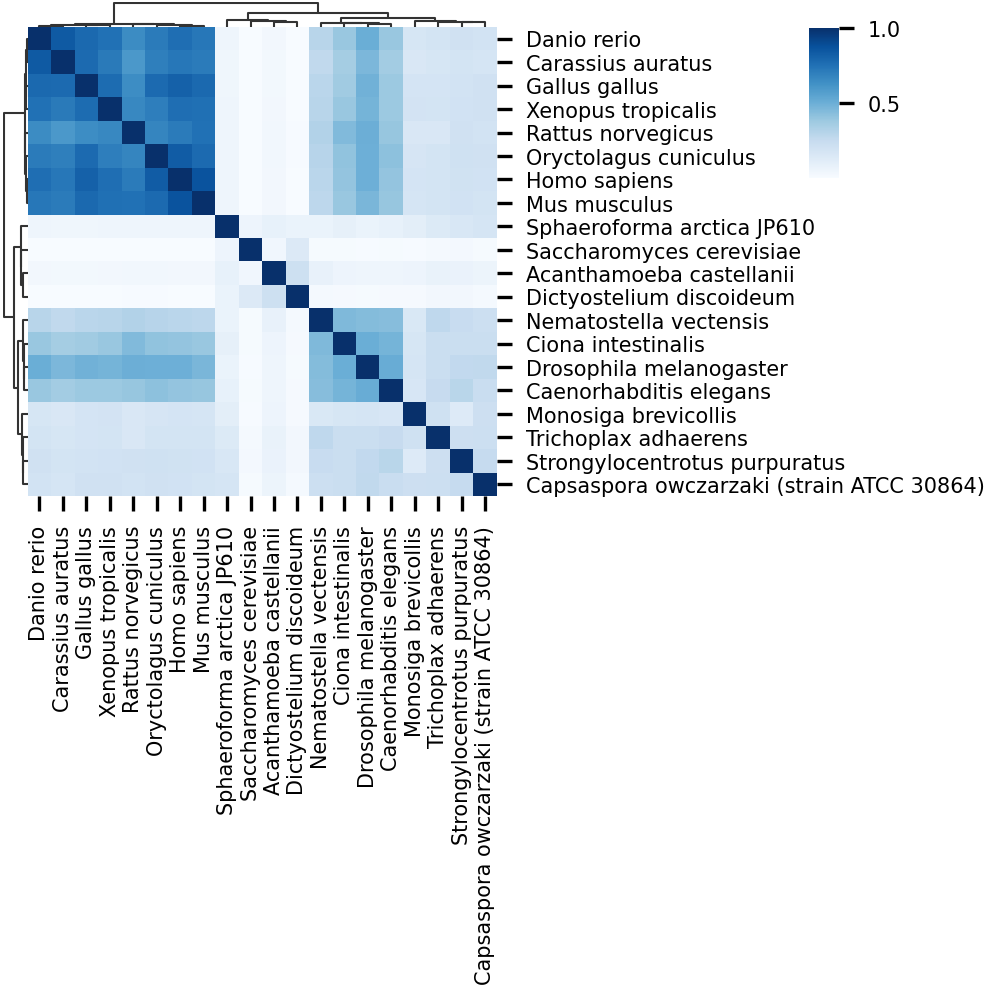

In [126]:
similarity_matrix = pd.DataFrame(np.nan,columns = species_adj_orig.keys(), index = species_adj_orig.keys())

for i in range(similarity_matrix.shape[1]):
    species1 = species_archs.columns[i]
    for j in range(similarity_matrix.shape[1]):
        species2 = species_archs.columns[j]
        set1 = set(species_archs[species_archs[species1]==1].index)
        set2 = set(species_archs[species_archs[species2]==1].index)

        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        jaccard = intersection/union

        similarity_matrix.iloc[i,j] = jaccard
        similarity_matrix.iloc[j,i] = jaccard
    similarity_matrix.iloc[i,i] = 1

sns.clustermap(similarity_matrix, cmap='Blues',metric='euclidean',method='ward',dendrogram_ratio=0.05, cbar_pos=(1.35,.7,0.05,0.25))
plt.gcf().set_size_inches(2,2)
plt.gcf().set_dpi(300)
plt.savefig('Figures/Manuscript Figures/Supplementary Figure 10 Phospho N-gram Similarities/pTyr Species Similarity Matrix.svg')

## Still trying things out but what happens when there is a large all species network

In [127]:
all_ref_files = [v for v in reference_files.values()]

In [128]:
df = ngramUtilities.import_reference_file(all_ref_files)
interpro_conv = ngramUtilities.generate_interpro_conversion(df)
# Retrieving all possible Interpro IDs within the dataset
all_ids = [k for k in interpro_conv.keys()]

In [129]:

#df, interpro_conversion_dict = ngramUtilities.add_Interpro_ID_architecture(df)
#ngram_dict_sub, ngram_dict_full = ngramUtilities.get_ngrams_from_df(df,Interpro_ID, max_ngram=5)
#ngram_dict_concat, vals_to_delete = ngramUtilities.concatenate_ngrams(ngram_dict_sub)
adj_df, df, ngram_dict,removed_ngrams, interpro_conv = ngramUtilities.full_ngram_analysis(df, all_ids,min_arch=1, readable_flag=0,max_node_len=100, max_ngram=100)

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


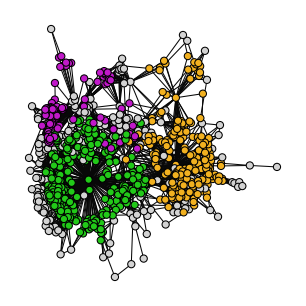

In [130]:
G_combo = nx.from_pandas_adjacency(adj_df)
G_combo.remove_edges_from(nx.selfloop_edges(G_combo))
#pos_combo  = nx.spring_layout(G_combo, seed = 5,k=0.15)
pos_combo = nx.nx_agraph.graphviz_layout(G_combo, prog='sfdp')

for node in G_combo.nodes():
        col = '#d3d3d3'
        sz = adj_df.loc[node, node]
        for domain, type in domain_categories.items():
                if domain in node:
                        col = color_cats[type]

        nx.set_node_attributes(G_combo, values={node:{'size':sz,'color':col}})
node_attribs = dict(G_combo.nodes(data=True))

plt.figure(figsize=(1,1),dpi=300)
nx.draw(G_combo, pos=pos_combo, 
        node_color=[v['color'] for v in node_attribs.values()],
        node_size = 3, edgecolors= 'k',
        edge_color = '#080808',
        width = 0.25, linewidths = 0.25) 

plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/All Species pY Network.svg', transparent=True)

In [131]:
full_p = entropyCalc.build_freq_dict_from_adj(adj_df,df['Interpro Domain Architecture IDs'], removed_ngrams)

In [ ]:
basic_labels = {'SH2':'SH2','PTP_cat_dom':'PTP_cat','Prot_kinase_dom':'Prot_kinase'}
kl = {}
netSum = {}
for species in species_list:

    temp_G = G[species].copy()
    
    superseded_nodes = []
    missing_nodes = [node for node in temp_G.nodes() if node not in G_combo.nodes()]
    
    for node in missing_nodes:
        for full_node in G_combo.nodes():
            if node in full_node:
                superseded_nodes.append(full_node)

    for node in missing_nodes:
        temp_G.remove_node(node)

    netSum[species] = {'Isolates':nx.number_of_isolates(temp_G),
                       'Connected Components':nx.number_connected_components(temp_G)}



In [133]:
h = {}
ce = {}
for species in species_summary:
    # Getting the relative entropy
    spec_adj = species_summary[species]['Complete Adjacency']
    spec_ref = species_summary[species]['Reference Data']
    spec_rm = species_summary[species]['Complete Removed N-grams']
    spec_p = entropyCalc.build_freq_dict_from_adj(spec_adj,spec_ref['Interpro Domain Architecture IDs'], spec_rm)
    h[species] = entropyCalc.crossEntropy(spec_p, spec_p)
    ce[species] = entropyCalc.crossEntropy(spec_p, full_p)
    kl[species] = entropyCalc.relativeEntropy(spec_p, full_p)

In [134]:
fn = entropyCalc.calc_FN_from_adjacency(adj_df,df['Interpro Domain Architecture IDs'], 10,removed_ngrams,db_check=1)

In [135]:
fn

2.7767620406969673

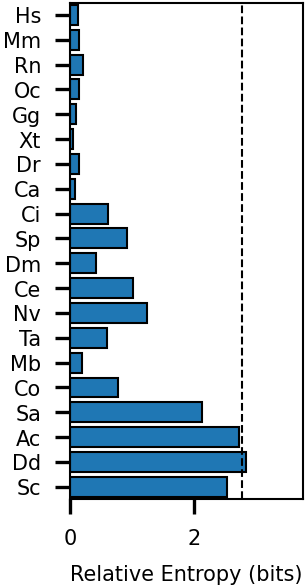

In [136]:
plt.figure(figsize=(1,2.15),dpi=300)
plt.barh(y = [species_columns[k] for k in kl.keys()], width=[v for v in kl.values()],edgecolor='k', linewidth=0.5)
plt.axvline(x = fn, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Relative Entropy (bits)')
plt.margins(y = 0.005)
plt.xlim(0,3.75)
plt.gca().invert_yaxis()
plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/Species Relative Entropy.svg', transparent=True)

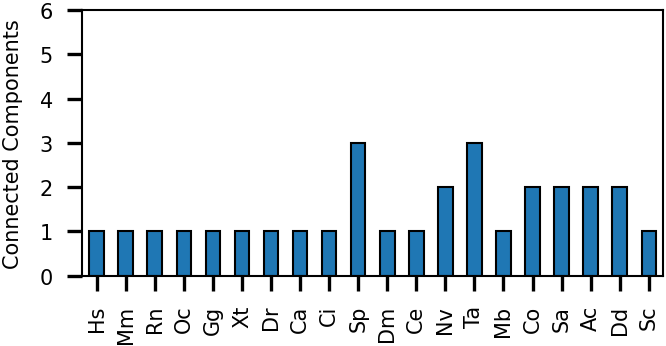

In [137]:
cc_data = pd.DataFrame.from_dict(netSum, orient='index')
cc_data.rename(index=species_columns,inplace=True)
cc_data['Connected Components'].plot.bar(edgecolor='k',linewidth=0.5)
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2.5,1.15)
plt.ylabel('Connected Components')
plt.ylim(0,6)
plt.savefig('Figures/Manuscript Figures/Figure 5 Signaling Submodule Checks/pTyr Connected Components.svg')

In [138]:
species_summary_pY = {**species_summary}

Repeating some of the above but with the pST system instead to show how it evolved over time.

In [139]:
reference_files = {}
for species in species_names:
    reference_files[species] = 'data/Current_Multispecies_pTyr/'+species_names[species]+'Full_pSerThr_System_Reference_File_May12_2025.csv'
multi_IDs = ['IPR001202','IPR023410','IPR000253','IPR001132','IPR001357','IPR002713','IPR000719','IPR001245','IPR004843','IPR006186']

for species in species_list:
    
    species_summary[species] = {}
    reference_file = reference_files[species]

    df = ngramUtilities.import_reference_file(reference_file)
    df,_ = ngramUtilities.add_Interpro_ID_architecture(df)
    spec_interpro_conv = ngramUtilities.generate_interpro_conversion(df)
    
    all_doms = [k for k in spec_interpro_conv.keys()]
    adj_comp, _, _,rm_comp, _ = ngramUtilities.full_ngram_analysis(df, all_doms, min_arch=1,readable_flag=0, max_node_len=100, max_ngram=100)
    adj_df, df, ngram_dict,removed_ngrams, interpro_conv = ngramUtilities.full_ngram_analysis(df, multi_IDs, min_arch=1,readable_flag=0, max_node_len=100, max_ngram=100)
    
    # Now getting the counts for individual domains and then filtering to only the ones associated with the system.
    ngram_list = Counter(sum(df['Interpro Domain Architecture IDs'].str.split('|'),[]))
    ngram_counts = {k:v for k,v in ngram_list.items() if k in multi_IDs}

    if species == 'Homo sapiens':
        ptyr_doms = {}
        for interpro_id in multi_IDs:
            if interpro_id in interpro_conv:
                ptyr_doms[interpro_id] = interpro_conv[interpro_id]
    
    species_summary[species]['Reference Data'] = df
    species_summary[species]['Adjacency Dataframe'] = adj_df
    species_summary[species]['Complete Adjacency'] = adj_comp
    species_summary[species]['N-gram Uniprot IDs'] = ngram_dict
    species_summary[species]['Removed N-grams'] = removed_ngrams
    species_summary[species]['Complete Removed N-grams'] = rm_comp
    species_summary[species]['Domain Counts'] = ngram_counts

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Starting to fetch n-grams.
Finished getting all n-grams
Starting to gene

In [140]:
species_adj_orig = {species:sum_info['Complete Adjacency'] for (species, sum_info) in species_summary.items()}
species_removed_ngrams = {species:sum_info['Removed N-grams'] for (species, sum_info) in species_summary.items()}

In [141]:
domain_categories = {'Reader':['IPR001202','IPR023410','IPR000253','IPR001132','IPR001357','IPR002713'], 
                     'Writer':['IPR000719','IPR001245'],
                     'Eraser':['IPR004843','IPR006186']} #,'IPR000387','IPR003595']}

v_list = []
k_list = []
for (k,v) in domain_categories.items():
    v_list += v
    dup_k = [k]*len(v)
    k_list += dup_k
domain_categories = dict(zip(v_list, k_list))
dom_colors = {}
writer = '#22c919' #orange
eraser = '#c019c9' #purple
reader = '#f2b120' #green
color_cats = {'Reader':reader, 'Writer':writer, 'Eraser':eraser,'Multiple':'#3b78d6'}

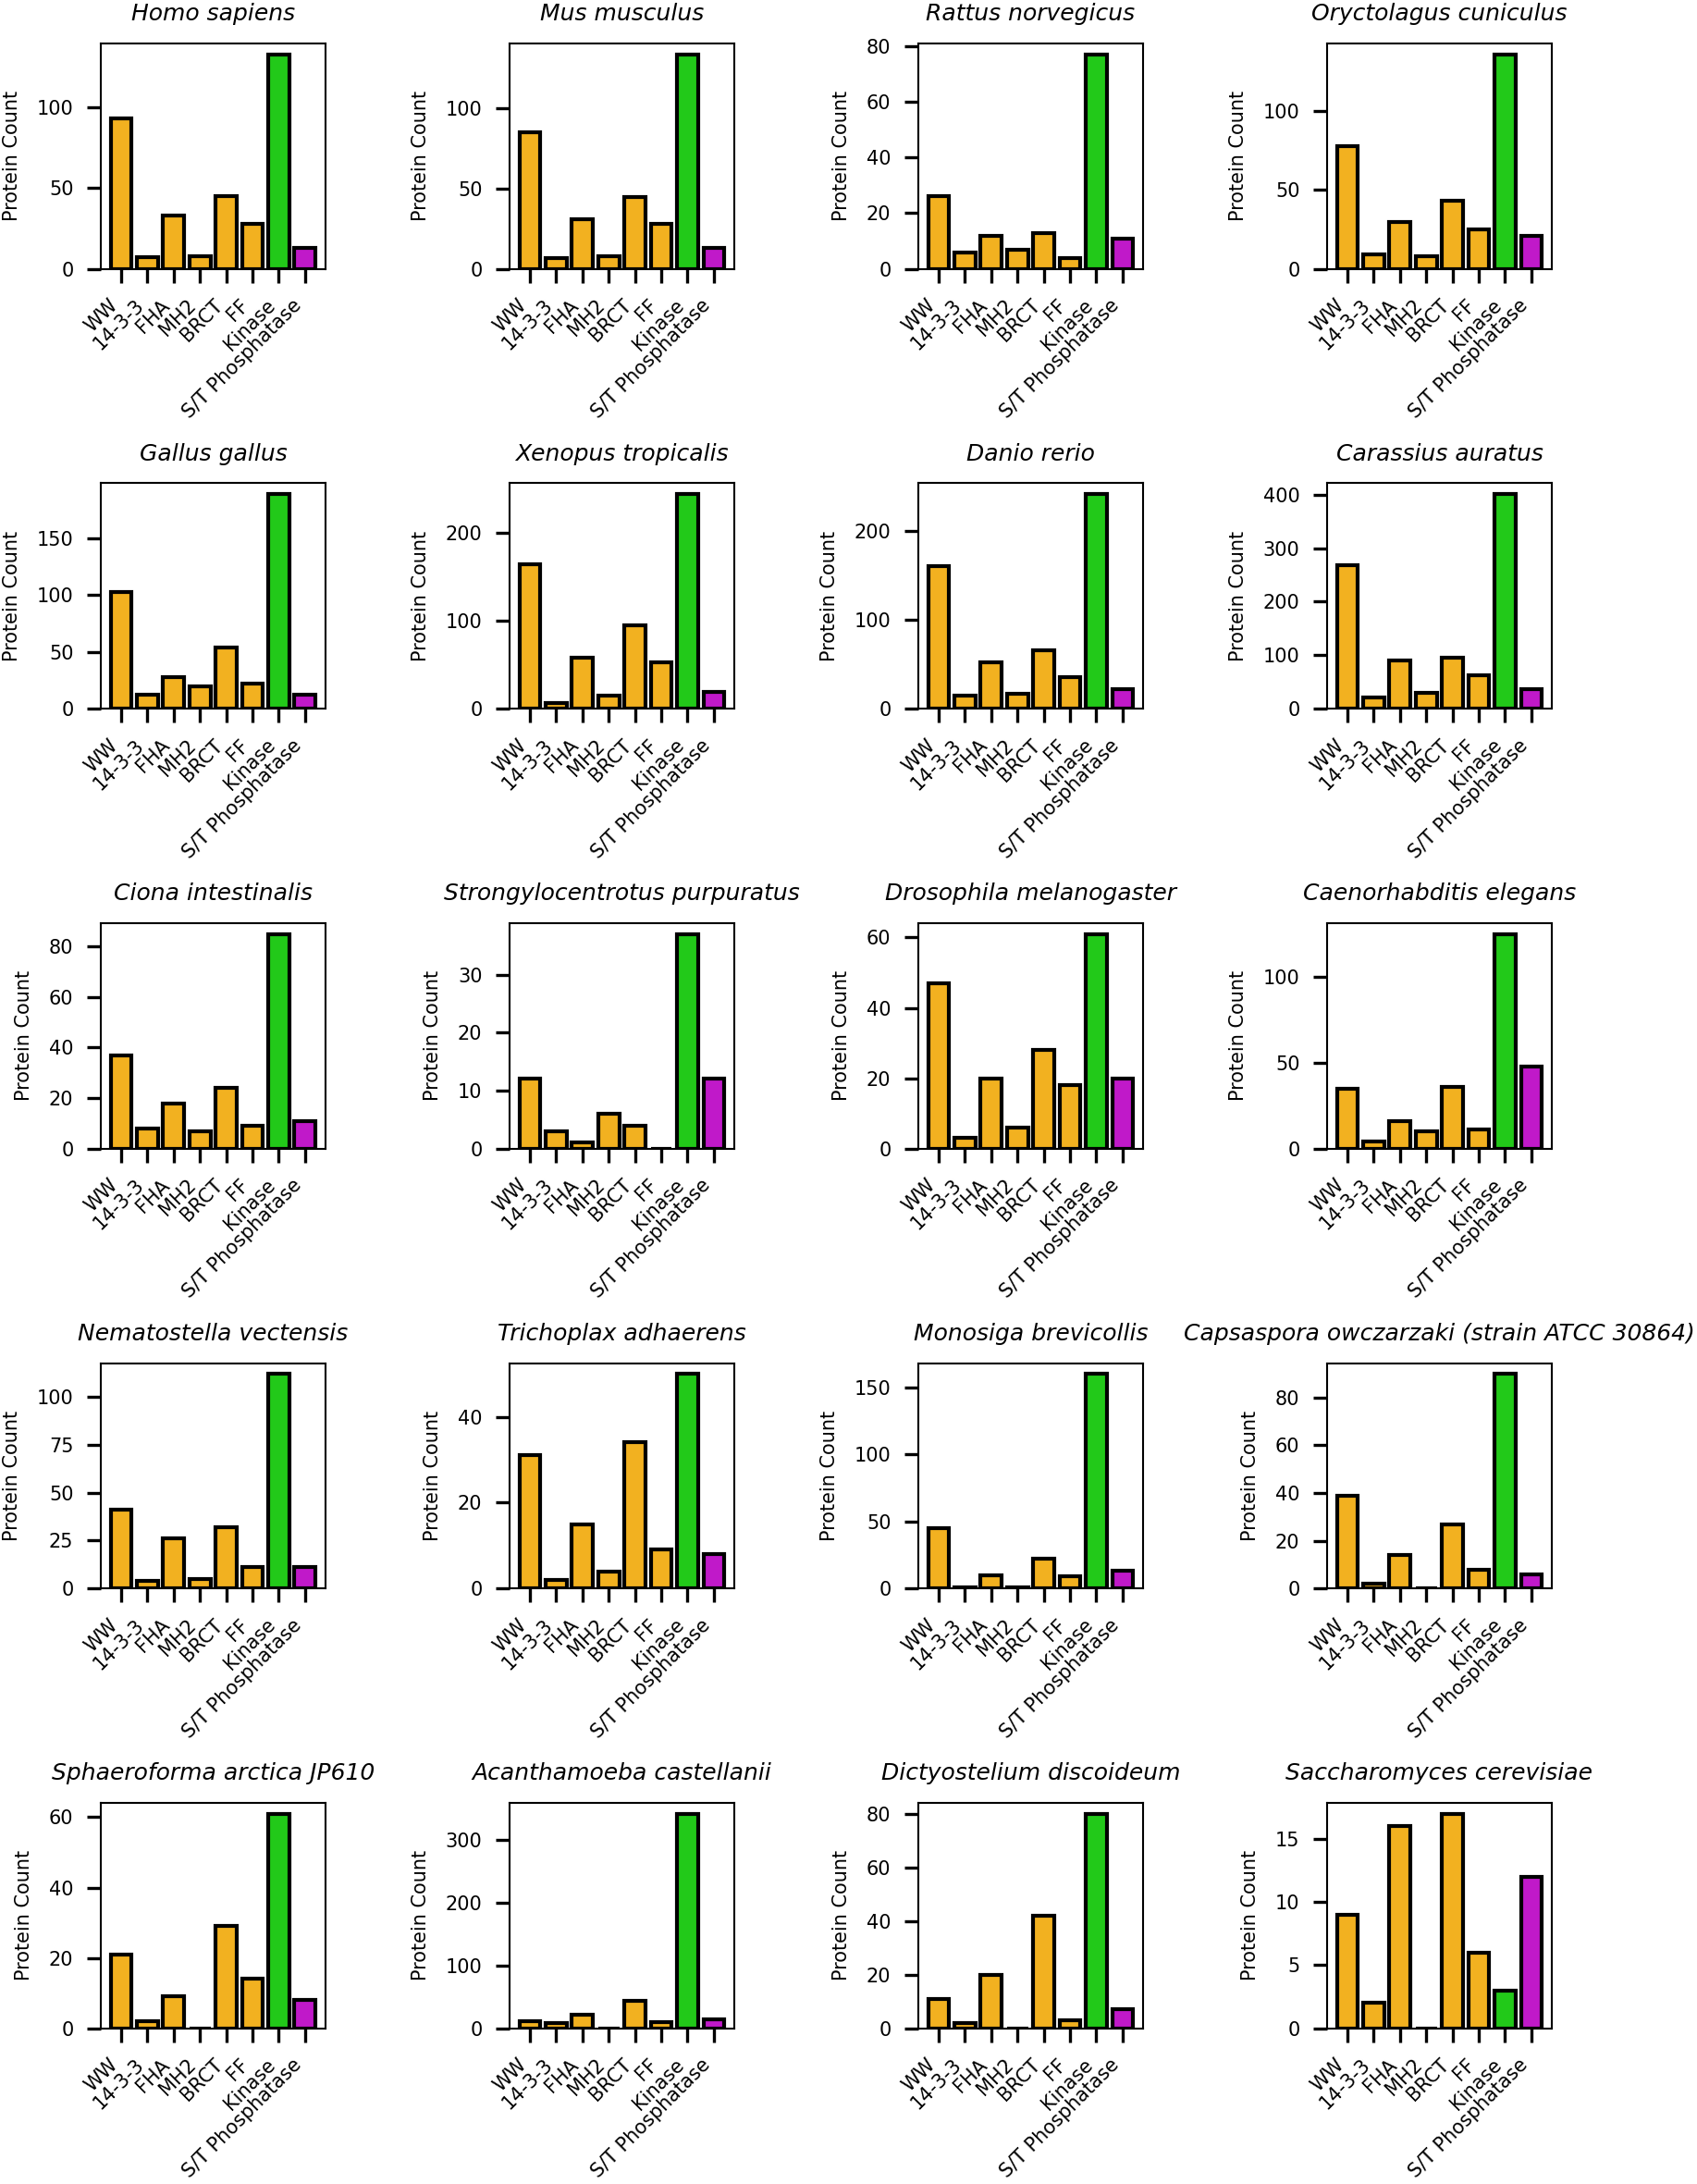

In [ ]:
tk_doms = [k for k in ptyr_doms.keys()]
dom_names = [v for v in ptyr_doms.values()]
tk_cols = [color_cats[domain_categories[k]] for k in ptyr_doms.keys()]

tk_df = pd.DataFrame(0, index=list(species_summary.keys()), columns=tk_doms)
subplotCount = 1
plt.figure(figsize=(6.25,8), dpi=300, layout = 'tight')
for species in species_summary:
    counts = species_summary[species]['Domain Counts']
    for tk in tk_doms:
        if tk in counts:
            tk_df.loc[species, tk] = counts[tk]
    plt.subplot(5,4,subplotCount)
    plt.bar(height=tk_df.loc[species],x=tk_doms, color = tk_cols,edgecolor = 'black')
    plt.title(species,style = 'italic')
    plt.xticks(tk_doms,labels=['WW','14-3-3','FHA','MH2','BRCT','FF','Kinase','S/T Phosphatase'],rotation=45, horizontalalignment='right')
    plt.ylabel('Protein Count')
    ax = plt.gca()
    ax.set_box_aspect(1)
    subplotCount +=1
plt.savefig('Figures/Manuscript Figures/Supplementary Figure 8 Phosphorylation Domain Evolution/Species pST Domain Breakdown.svg')

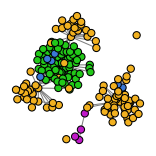

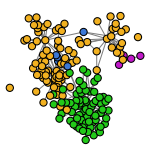

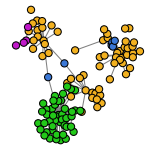

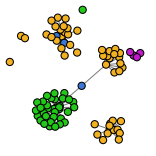

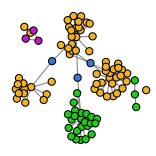

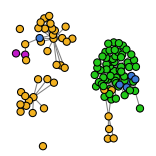

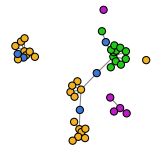

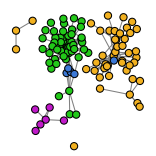

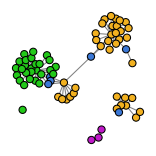

In [100]:
# Generating the network from the adjacency matrix.
G = {}
pos = {}

#subplotCount = 1
#plt.figure(figsize=(1,1), dpi=300, layout = 'tight')
for species in species_summary:
    spec_adj = species_summary[species]['Adjacency Dataframe']
    G_spec = nx.from_pandas_adjacency(spec_adj)
    G_spec.remove_edges_from(nx.selfloop_edges(G_spec))
    pos[species]  = nx.spring_layout(G_spec, seed = 882, k = 0.25) #Setting positions of each node based on the spring model
    
    for node in G_spec.nodes():
        col = '#d3d3d3'
        sz = spec_adj.loc[node, node]
        new_flag = True
        for domain, type in domain_categories.items():
            if domain in node:
                if new_flag:
                    col = color_cats[type]
                    new_flag = False

                else:
                    col = color_cats['Multiple']
        
        nx.set_node_attributes(G_spec, values={node:{'size':sz,'color':col}})
    
    G[species] = G_spec
    if species in species_2_plt:
        node_attribs = dict(G_spec.nodes(data = True))
        plt.figure(figsize=(0.5,0.5),dpi = 300)
        nx.draw(G_spec, pos=pos[species], 
            node_color=[v['color'] for v in node_attribs.values()], 
            node_size = 3, 
            edgecolors= 'k',
            font_size=10, edge_color = '#808080', width = 0.25, linewidths = 0.25)
        plt.savefig(f'Figures/Manuscript Figures/Figure 4 PTM System Analysis/Species Networks/pST {species} Full.svg', transparent=True)

    node_attribs = dict(G_spec.nodes(data = True))
    plt.figure(figsize=(1,1),dpi = 300)
    nx.draw(G_spec, pos=pos[species], 
        node_color=[v['color'] for v in node_attribs.values()], 
        node_size = 2, 
        edgecolors= 'k',
        font_size=10, edge_color = '#808080', width = 0.25, linewidths = 0.25)
    plt.title(species_plt_names[species])
    plt.axis('on')
    plt.savefig(f'Figures/Manuscript Figures/Supplemental Figure Expanded Species pSerThr Networks/pST {species}.svg')
    plt.close()
    

In [ ]:
# To check whether the architectures are mostly similar between species next going to compute the Jaccard Similarity index for just identified architectures. (Note not taking into account the number of each for the time being)
species_columns = {}
for species in species_adj_orig.keys():
    species_label = species.split(' ')
    species_label = species_label[0:2]
    species_label = ''.join([n[0] for n in species_label])
    species_columns[species] = species_label

species_archs = pd.DataFrame(columns=species_columns.values())
species_archs_count = species_archs.copy()
for species, adj in species_adj_orig.items():
    domain_archs = adj.columns
    spec_lab = species_columns[species]
    for arch in domain_archs:
        if arch not in species_archs.index:
            temp = [0]*len(species_adj_orig)
            species_archs.loc[arch] = temp
            species_archs_count.loc[arch] = temp
        species_archs_count[spec_lab][arch] = adj.loc[arch][arch]
        species_archs[spec_lab][arch] = 1

# Checking if any of the n-grams were omitted due to being in the removed n-grams 

for arch in species_archs.index:
    for species in species_removed_ngrams.keys():
        spec_lab = species_columns[species]
        if species_archs[spec_lab][arch] == 0:
            if arch in species_removed_ngrams[species]:
                species_archs[spec_lab][arch] = 1
                

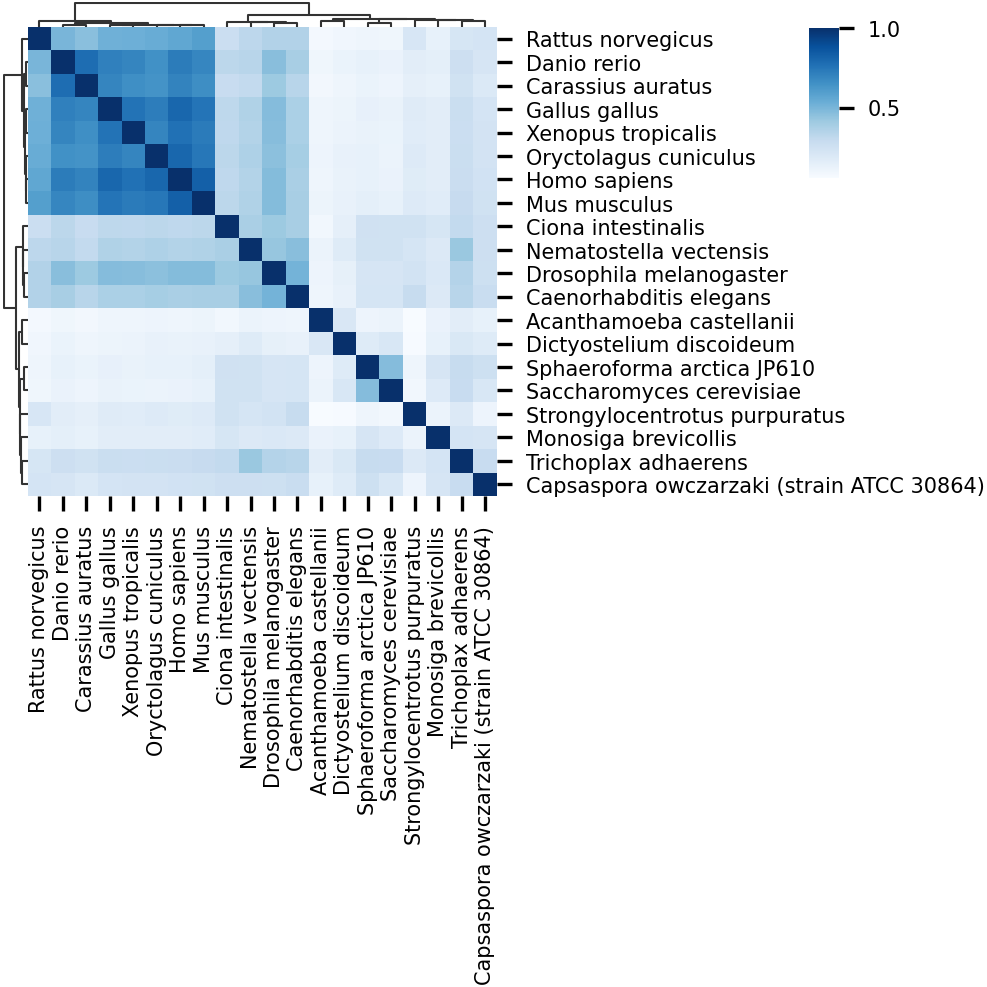

In [102]:
similarity_matrix = pd.DataFrame(np.nan,columns = species_adj_orig.keys(), index = species_adj_orig.keys())

for i in range(similarity_matrix.shape[1]):
    species1 = species_archs.columns[i]
    for j in range(similarity_matrix.shape[1]):
        species2 = species_archs.columns[j]
        set1 = set(species_archs[species_archs[species1]==1].index)
        set2 = set(species_archs[species_archs[species2]==1].index)

        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        jaccard = intersection/union

        similarity_matrix.iloc[i,j] = jaccard
        similarity_matrix.iloc[j,i] = jaccard
    similarity_matrix.iloc[i,i] = 1

sns.clustermap(similarity_matrix, cmap='Blues',metric='euclidean',method='ward',dendrogram_ratio=0.05, cbar_pos=(1.35,.7,0.05,0.25))
plt.gcf().set_size_inches(2,2)
plt.gcf().set_dpi(300)
plt.savefig('Figures/Manuscript Figures/Supplementary Figure 10 Phospho N-gram Similarities/pST Species Similarity Matrix.svg')

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.


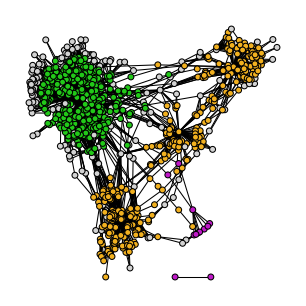

In [ ]:
all_ref_files = [v for v in reference_files.values()]
df = ngramUtilities.import_reference_file(all_ref_files)
interpro_conv = ngramUtilities.generate_interpro_conversion(df)
# Retrieving all possible Interpro IDs within the dataset
all_ids = [k for k in interpro_conv.keys()]
adj_df, df, ngram_dict,removed_ngrams, interpro_conv = ngramUtilities.full_ngram_analysis(df, all_ids,min_arch=1, readable_flag=0,max_node_len=100,max_ngram=100)

G_combo = nx.from_pandas_adjacency(adj_df)
G_combo.remove_edges_from(nx.selfloop_edges(G_combo))
#pos_combo  = nx.spring_layout(G_combo, seed = 5,k=0.1)
pos_combo  = nx.nx_agraph.graphviz_layout(G_combo, prog='sfdp')

for node in G_combo.nodes():
        col = '#d3d3d3'
        sz = adj_df.loc[node, node]
        for domain, type in domain_categories.items():
                if domain in node:
                        col = color_cats[type]

        nx.set_node_attributes(G_combo, values={node:{'size':sz,'color':col}})
node_attribs = dict(G_combo.nodes(data=True))

plt.figure(figsize=(1,1),dpi=300)
nx.draw(G_combo, pos=pos_combo, 
        node_color=[v['color'] for v in node_attribs.values()],
        node_size = 2, edgecolors= 'k',
        edge_color = 'k',
        width = 0.25, linewidths = 0.25) 
plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/All Species pST Network.svg', transparent=True)


In [ ]:
netSum = {}
for species in species_list:
    
    temp_G = G[species].copy()
    
    superseded_nodes = []
    missing_nodes = [node for node in temp_G.nodes() if node not in G_combo.nodes()]
    
    for node in missing_nodes:
        for full_node in G_combo.nodes():
            if node in full_node:
                superseded_nodes.append(full_node)

    for node in missing_nodes:
        temp_G.remove_node(node)

    netSum[species] = {'Isolates':nx.number_of_isolates(temp_G),
                       'Connected Components':nx.number_connected_components(temp_G)}


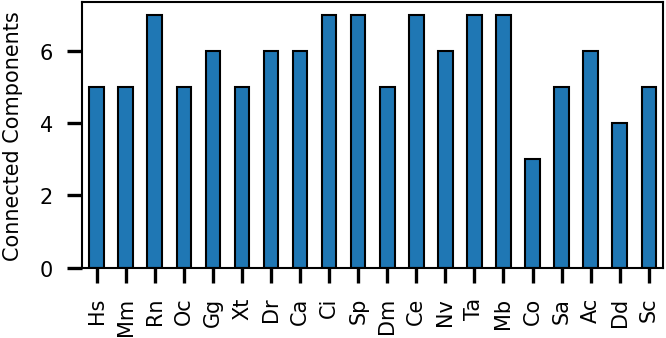

In [107]:
cc_data = pd.DataFrame.from_dict(netSum, orient='index')
cc_data.rename(index=species_columns,inplace=True)
cc_data['Connected Components'].plot.bar(edgecolor='k',linewidth=0.5)
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2.5,1.15)
plt.ylabel('Connected Components')
plt.savefig('Figures/Manuscript Figures/Figure 5 Signaling Submodule Checks/pST Connected Components.svg')

In [108]:
full_p = entropyCalc.build_freq_dict_from_adj(adj_df,df['Interpro Domain Architecture IDs'], removed_ngrams)
h = {}
ce = {}
for species in species_summary:
    # Getting the relative entropy
    spec_adj = species_summary[species]['Complete Adjacency']
    spec_ref = species_summary[species]['Reference Data']
    spec_rm = species_summary[species]['Complete Removed N-grams']
    spec_p = entropyCalc.build_freq_dict_from_adj(spec_adj,spec_ref['Interpro Domain Architecture IDs'], spec_rm)
    h[species] = entropyCalc.crossEntropy(spec_p, spec_p)
    ce[species] = entropyCalc.crossEntropy(spec_p, full_p)
    kl[species] = entropyCalc.relativeEntropy(spec_p, full_p)

In [109]:
fn = entropyCalc.calc_FN_from_adjacency(adj_df,df['Interpro Domain Architecture IDs'], 10,removed_ngrams,db_check=1)

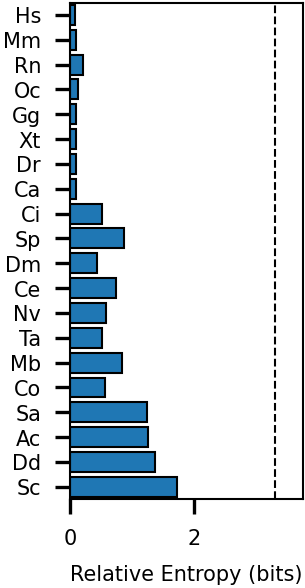

In [110]:
plt.figure(figsize=(1,2.15),dpi=300)
plt.barh(y = [species_columns[k] for k in kl.keys()], width=[v for v in kl.values()],edgecolor='k', linewidth=0.5)
plt.axvline(x = fn, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Relative Entropy (bits)')
plt.margins(y = 0.005)
plt.xlim(0,3.75)
plt.gca().invert_yaxis()
plt.savefig('Figures/Manuscript Figures/Figure 4 PTM System Analysis/Species Relative Entropy pST.svg', transparent=True)